# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

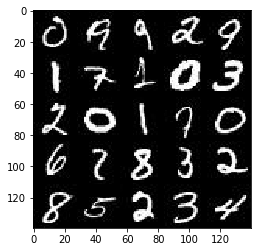

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

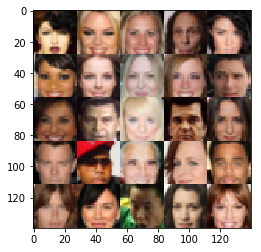

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    input_lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, input_lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.01 # hardcoded based on DCGAN project implemenation guidance
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flattening
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if is_train:
        reuse=False
    else:
        reuse=True
    with tf.variable_scope('generator', reuse=reuse):
        
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 2*2*512)

        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every=10
    show_every=100
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, input_lr = model_inputs(image_width, image_height, len(data_image_mode), z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr:learning_rate})
                # not entirely sure why running this twice is the trick. Maybe because epochs is static for the project?
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.2188... Generator Loss: 0.0571
Epoch 1/2... Discriminator Loss: 2.7522... Generator Loss: 0.1008
Epoch 1/2... Discriminator Loss: 2.7629... Generator Loss: 0.1316
Epoch 1/2... Discriminator Loss: 2.4193... Generator Loss: 0.1925
Epoch 1/2... Discriminator Loss: 1.9834... Generator Loss: 0.2740
Epoch 1/2... Discriminator Loss: 1.7685... Generator Loss: 0.3736
Epoch 1/2... Discriminator Loss: 1.6741... Generator Loss: 0.3656
Epoch 1/2... Discriminator Loss: 1.5864... Generator Loss: 0.4738
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 1.5092... Generator Loss: 0.5241


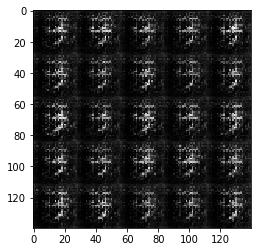

Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 0.9711
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 0.7915
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9750
Epoch 1/2... Discriminator Loss: 0.5244... Generator Loss: 1.4321
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 1.3613
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.0398
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 1.2977


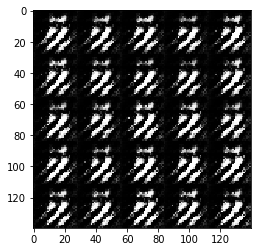

Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 0.2800... Generator Loss: 1.9852
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 1.5118
Epoch 1/2... Discriminator Loss: 0.3722... Generator Loss: 1.7892
Epoch 1/2... Discriminator Loss: 0.3110... Generator Loss: 1.9851
Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 1.2827


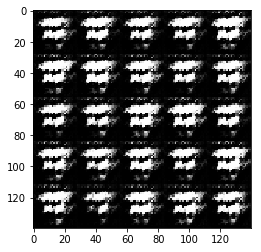

Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 1.6877
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 1.2705
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 1.4938
Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 0.8528... Generator Loss: 1.2453
Epoch 1/2... Discriminator Loss: 0.9790... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 0.4582... Generator Loss: 1.7275


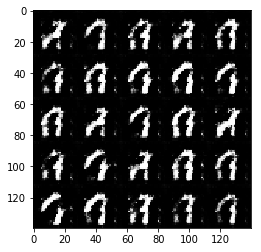

Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 1.5289
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.1630
Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 1.5583
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 1.0482
Epoch 1/2... Discriminator Loss: 0.4979... Generator Loss: 1.6304
Epoch 1/2... Discriminator Loss: 0.6835... Generator Loss: 1.1470
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 1.3670


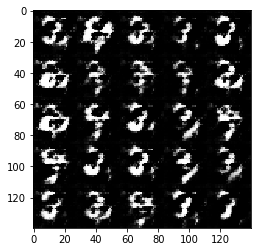

Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.1157
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 1.2376
Epoch 1/2... Discriminator Loss: 0.8308... Generator Loss: 1.0916
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 1.0112
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 0.9810
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 0.9454
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 0.7937


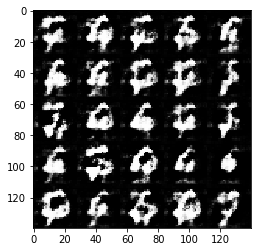

Epoch 1/2... Discriminator Loss: 1.1524... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 1.2311
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 1.0577
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.0988
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 0.8123
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 0.8382... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 0.8387... Generator Loss: 1.1184


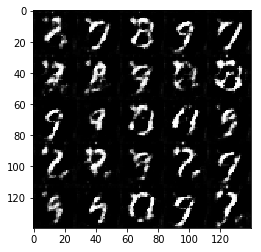

Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.9942
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 1.6216... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.3127
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 1.2168
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 0.8481


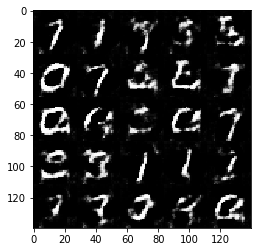

Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 1.0850
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.4907
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.5334... Generator Loss: 0.3106
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.3876


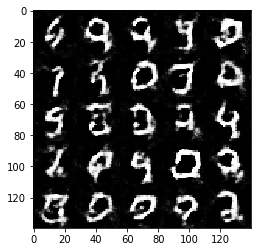

Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 1.1792
Epoch 1/2... Discriminator Loss: 1.5886... Generator Loss: 0.3013
Epoch 1/2... Discriminator Loss: 1.2792... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.5657
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.0747... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.5495


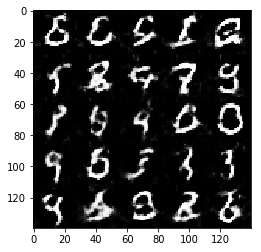

Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.5383
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.5187
Epoch 1/2... Discriminator Loss: 1.4729... Generator Loss: 0.3969
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 1.1755
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.9243


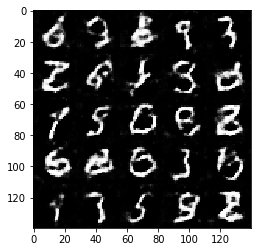

Epoch 1/2... Discriminator Loss: 1.4346... Generator Loss: 0.4642
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.5264
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.6541... Generator Loss: 0.3740
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.5743


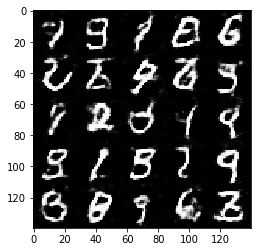

Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.3916
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.2949... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 1.9170... Generator Loss: 0.2018
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.4772
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 0.8541
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.7335
Epoch 1/2... Discriminator Loss: 1.5600... Generator Loss: 0.6219


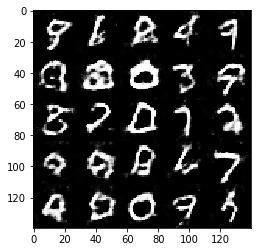

Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.5553... Generator Loss: 0.4103
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.5026
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.4005
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.5489
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 1.0509
Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 0.6545


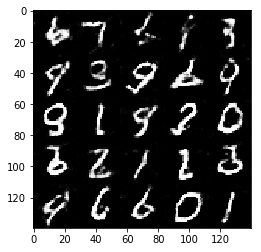

Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.5505
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.4685
Epoch 1/2... Discriminator Loss: 1.9428... Generator Loss: 0.1843
Epoch 1/2... Discriminator Loss: 1.4836... Generator Loss: 0.3457
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.5801... Generator Loss: 0.4761
Epoch 1/2... Discriminator Loss: 1.6762... Generator Loss: 0.3218
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.9822


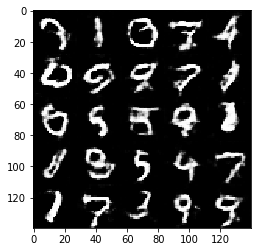

Epoch 1/2... Discriminator Loss: 1.8386... Generator Loss: 0.2141
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.4137
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.4431
Epoch 1/2... Discriminator Loss: 1.5486... Generator Loss: 0.3280
Epoch 1/2... Discriminator Loss: 1.7742... Generator Loss: 0.2334
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 0.5376


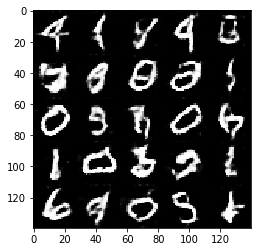

Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.9513
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.3696
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.8780
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.4265
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 1.0008


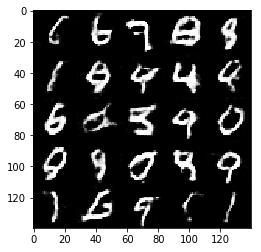

Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.4574
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.3571
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.4500
Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.5562
Epoch 1/2... Discriminator Loss: 1.9213... Generator Loss: 0.1980


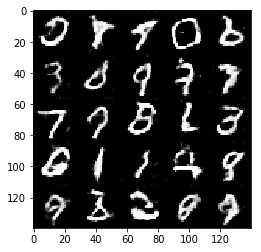

Epoch 1/2... Discriminator Loss: 1.4259... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 1.5290... Generator Loss: 0.3990
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 0.3223
Epoch 1/2... Discriminator Loss: 1.6155... Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.3944
Epoch 2/2... Discriminator Loss: 1.4472... Generator Loss: 0.4925


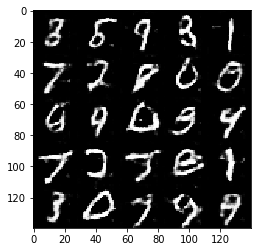

Epoch 2/2... Discriminator Loss: 1.6101... Generator Loss: 0.3186
Epoch 2/2... Discriminator Loss: 1.1832... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 1.7312... Generator Loss: 0.2500
Epoch 2/2... Discriminator Loss: 1.6252... Generator Loss: 0.2900
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.4754
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.3756
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.5373
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.5538


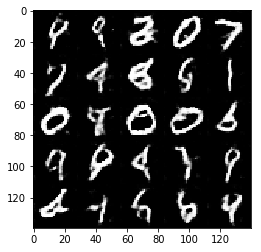

Epoch 2/2... Discriminator Loss: 1.8478... Generator Loss: 0.2229
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 1.0316
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.5109
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.3412
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.4806
Epoch 2/2... Discriminator Loss: 1.4245... Generator Loss: 0.4217
Epoch 2/2... Discriminator Loss: 1.4873... Generator Loss: 0.3292
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.5878
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.3788


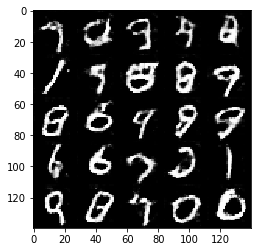

Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.4157
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.4884
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 0.6812
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.4765
Epoch 2/2... Discriminator Loss: 1.7921... Generator Loss: 0.2516
Epoch 2/2... Discriminator Loss: 1.1320... Generator Loss: 0.5905
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 1.7168... Generator Loss: 0.2349
Epoch 2/2... Discriminator Loss: 1.7675... Generator Loss: 0.2414
Epoch 2/2... Discriminator Loss: 1.8990... Generator Loss: 0.2416


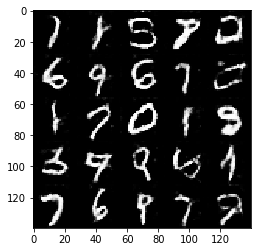

Epoch 2/2... Discriminator Loss: 1.6489... Generator Loss: 0.3305
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.4275... Generator Loss: 0.4371
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 1.3358
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.5981
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 1.6403... Generator Loss: 0.3101
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.4265
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 0.9268


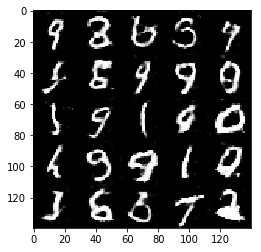

Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 0.5989
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.4545
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 1.6833... Generator Loss: 0.2814
Epoch 2/2... Discriminator Loss: 1.5261... Generator Loss: 0.3315
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.4723
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.5296
Epoch 2/2... Discriminator Loss: 1.5714... Generator Loss: 0.3719
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.1871... Generator Loss: 0.6376


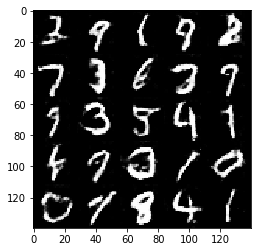

Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 0.9787
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.6229
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.4683
Epoch 2/2... Discriminator Loss: 1.4889... Generator Loss: 0.4262
Epoch 2/2... Discriminator Loss: 2.3209... Generator Loss: 0.1397
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.6097
Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 0.5390
Epoch 2/2... Discriminator Loss: 1.7999... Generator Loss: 0.3014
Epoch 2/2... Discriminator Loss: 2.1847... Generator Loss: 0.1482
Epoch 2/2... Discriminator Loss: 1.8223... Generator Loss: 0.2556


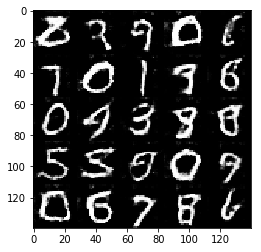

Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 1.6502... Generator Loss: 0.2688
Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.4890... Generator Loss: 0.3677
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.2882
Epoch 2/2... Discriminator Loss: 1.6443... Generator Loss: 0.3173
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 0.5236


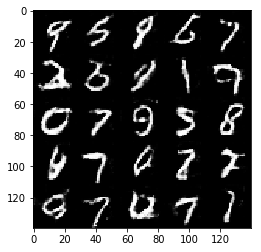

Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.6397
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.6587
Epoch 2/2... Discriminator Loss: 1.4542... Generator Loss: 0.4564
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 1.2261
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.3602
Epoch 2/2... Discriminator Loss: 1.9856... Generator Loss: 0.1847
Epoch 2/2... Discriminator Loss: 1.6022... Generator Loss: 0.3506
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 1.4788... Generator Loss: 0.3604


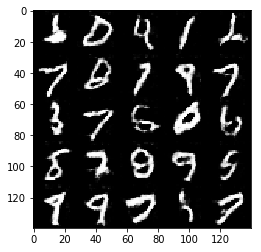

Epoch 2/2... Discriminator Loss: 2.5622... Generator Loss: 0.1108
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.5624
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 1.7429... Generator Loss: 0.2381
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.7653
Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 2.1967
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.4469
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.5178
Epoch 2/2... Discriminator Loss: 2.0064... Generator Loss: 0.1809
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.3514


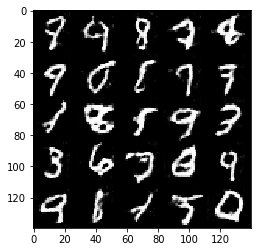

Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.5882
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 2.0668... Generator Loss: 0.1834
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.4016
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 0.6231
Epoch 2/2... Discriminator Loss: 1.8994... Generator Loss: 0.1961
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 0.4562
Epoch 2/2... Discriminator Loss: 1.4311... Generator Loss: 0.4871
Epoch 2/2... Discriminator Loss: 1.4225... Generator Loss: 0.5370


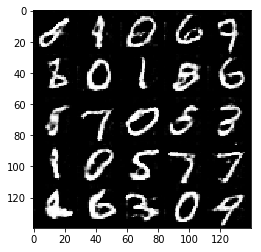

Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.4223
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 1.1681
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.5254
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.5476
Epoch 2/2... Discriminator Loss: 1.5819... Generator Loss: 0.2904
Epoch 2/2... Discriminator Loss: 1.5981... Generator Loss: 0.3405
Epoch 2/2... Discriminator Loss: 1.7742... Generator Loss: 0.2747
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 0.9248
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 0.7987
Epoch 2/2... Discriminator Loss: 2.1782... Generator Loss: 0.1526


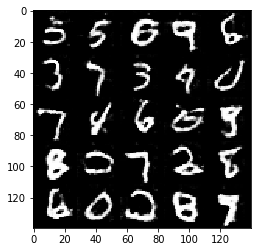

Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.4889
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.8725
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.4513
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 1.0922... Generator Loss: 0.5499
Epoch 2/2... Discriminator Loss: 1.9546... Generator Loss: 0.2326
Epoch 2/2... Discriminator Loss: 1.9864... Generator Loss: 0.1917
Epoch 2/2... Discriminator Loss: 1.4708... Generator Loss: 0.4084


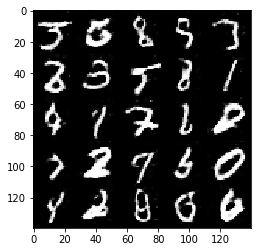

Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.5503
Epoch 2/2... Discriminator Loss: 1.4857... Generator Loss: 0.3972
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.5449
Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 1.7677
Epoch 2/2... Discriminator Loss: 1.5883... Generator Loss: 0.3078
Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.5174
Epoch 2/2... Discriminator Loss: 1.4904... Generator Loss: 0.3659
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 1.1823


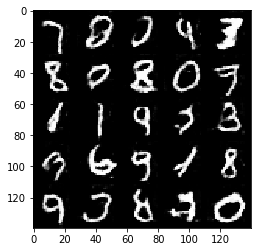

Epoch 2/2... Discriminator Loss: 1.7713... Generator Loss: 0.2989
Epoch 2/2... Discriminator Loss: 1.1972... Generator Loss: 0.6099
Epoch 2/2... Discriminator Loss: 1.6323... Generator Loss: 0.2972
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 1.8236... Generator Loss: 0.2398
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.3267
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.4288... Generator Loss: 0.5381
Epoch 2/2... Discriminator Loss: 2.0956... Generator Loss: 0.1785


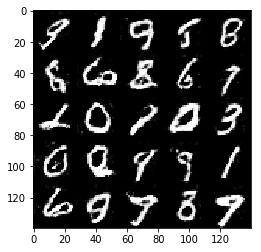

Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.6073
Epoch 2/2... Discriminator Loss: 1.5224... Generator Loss: 0.3676
Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 0.3476
Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 1.3630
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 2.0344
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.6540
Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 0.9369
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.9881
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.5205


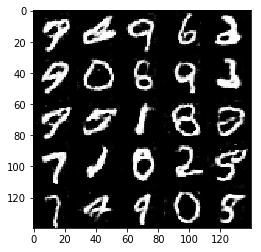

Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 0.8673
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.4358
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.6280
Epoch 2/2... Discriminator Loss: 1.8332... Generator Loss: 0.2391
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 1.0731
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.6175
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 1.0243
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 0.8983


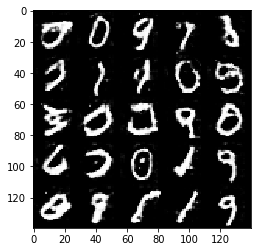

Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.0652
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.6055
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 1.4417
Epoch 2/2... Discriminator Loss: 1.5060... Generator Loss: 0.3261
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 1.7006... Generator Loss: 0.2785
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.4973


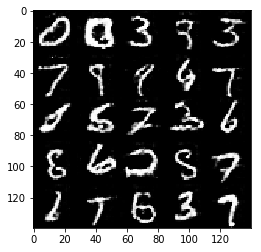

Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.4117
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 0.4078
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.6372... Generator Loss: 0.3758
Epoch 2/2... Discriminator Loss: 1.4932... Generator Loss: 0.4074
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.7134
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.6224
Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 0.5694


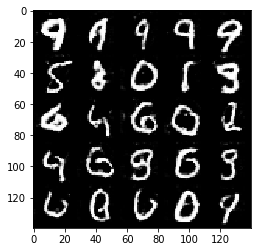

Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 0.4679
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.4637... Generator Loss: 0.3653
Epoch 2/2... Discriminator Loss: 0.7886... Generator Loss: 1.1241
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 0.6238


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.5512... Generator Loss: 0.0489
Epoch 1/1... Discriminator Loss: 2.6099... Generator Loss: 0.1268
Epoch 1/1... Discriminator Loss: 2.1485... Generator Loss: 0.2424
Epoch 1/1... Discriminator Loss: 1.7881... Generator Loss: 0.3536
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.0414


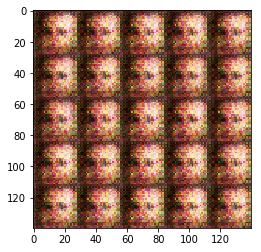

Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.9776


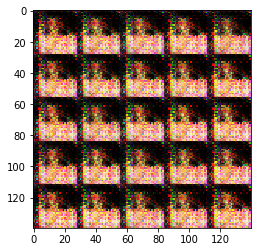

Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.2228
Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 1.4531
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 1.6078
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.2614... Generator Loss: 2.2617
Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 1.8356


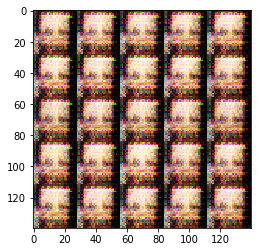

Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 1.8829
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 0.5356


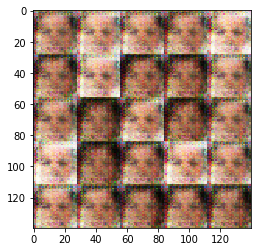

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6917


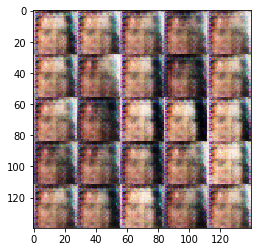

Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.6857


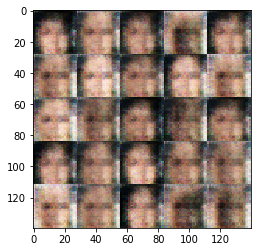

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7562


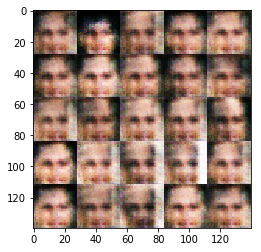

Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.8704


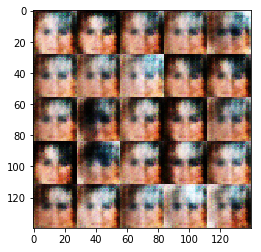

Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6676


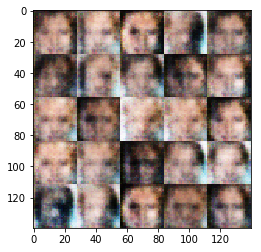

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7151


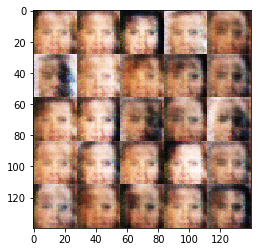

Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6641


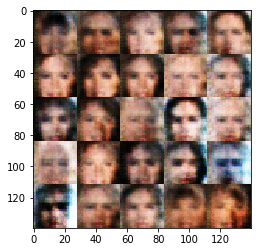

Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.6142


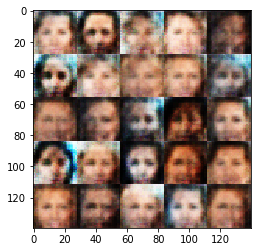

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6672


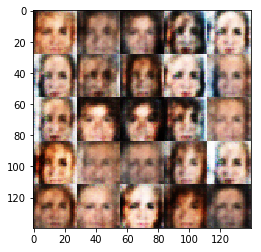

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7242


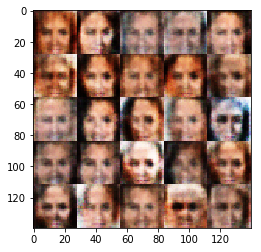

Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6494


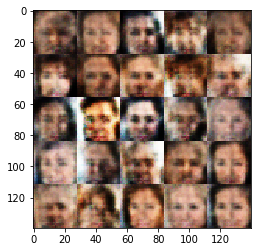

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6592


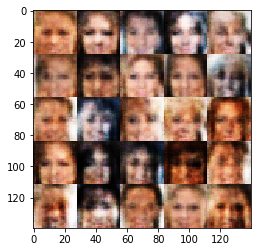

Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6658


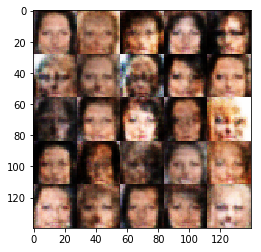

Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6549


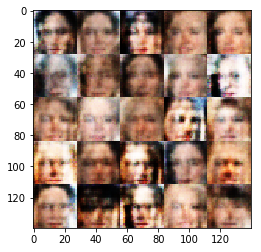

Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6686


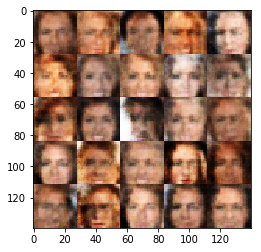

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6673


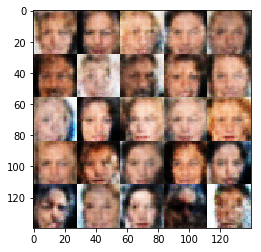

Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6812


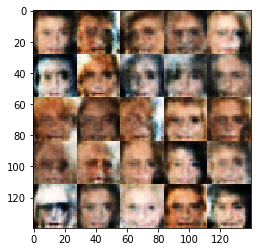

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6214


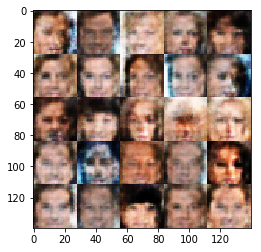

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6573


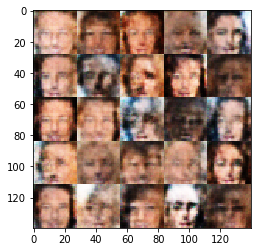

Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6721


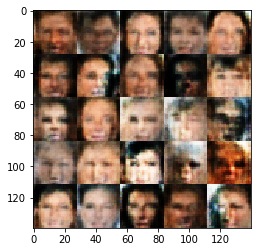

Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6742


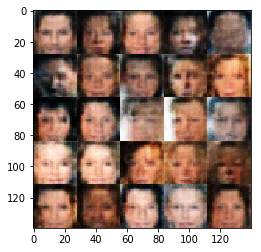

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6471


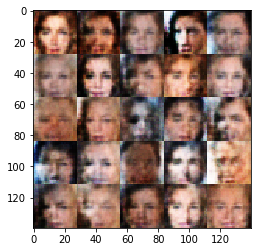

Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6319


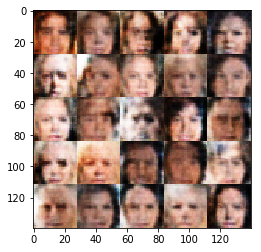

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6774


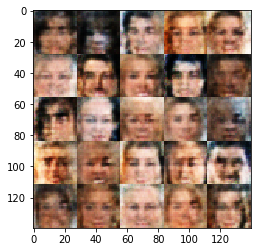

Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6369


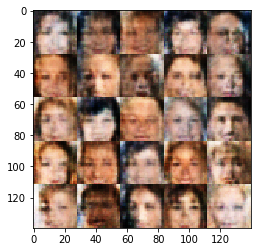

Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6436


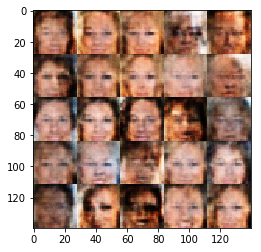

Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6424


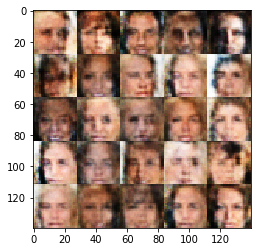

Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6503


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.